Let's begin by loading the libraries:

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl

from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset

/home/pablo/.micromamba/envs/mdl_gen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The following code is necessary (on my machine at least) to be able to use multiple processes for data loading.

In [3]:
import torch.multiprocessing as mp
mp.set_start_method('fork', force=True)

## Introduction  
In this *notebook*, we will implement a **Variational Autoencoder (VAE)** and
train it on a dataset of faces.  A **Variational Autoencoder (VAE)** is a type
of generative model that uses deep learning techniques to generate new data
instances similar to a given dataset. It builds upon the framework of
traditional autoencoders by introducing a probabilistic approach to learning the
latent space, which is a compressed representation of the input data. Unlike
standard autoencoders that directly map inputs to a latent representation and
back, VAEs impose a probabilistic structure on the latent space, enabling them
to generate new, meaningful data by sampling from this latent distribution.

VAEs achieve this by combining an encoder, which maps input data to a
distribution in the latent space, and a decoder, which reconstructs data from a
sample drawn from this distribution. The training process uses a loss function
that balances two objectives: reconstruction accuracy and the regularization of
the latent space, typically enforced using a Kullback-Leibler (KL) divergence
term. This regularization ensures that the learned latent space is smooth and
allows for meaningful interpolation and sampling. VAEs have been widely applied
in areas such as image synthesis, anomaly detection, and data augmentation due
to their ability to generate diverse and coherent outputs.

The *notebook* is divided into the following sections:  
* Data loading.  
* Model definition.  
* Training.  
* Examples of model usage.  

## Data loading

We implement the data-loading process with *data augmentation* applied to the training data. Although our model is probabilistic and does not allow for a deterministic measure of performance on the validation data, this process provides an idea of the difference in performance between training and validation data.  

We also note that only minimal *data augmentation* is applied, specifically reflections. This is because the task is not a classification problem; instead, we aim to generate realistic face images. Thus, augmentations like color or saturation distortions could lead to the generation of such distortions later. Rotation is also excluded, as it resulted in a loss of quality due to the image resolution.

In [4]:
IMAGE_SIZE = 64  # use images of 64x64 pixels

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

In [5]:
dataset = load_dataset("tpremoli/CelebA-attrs")

/home/pablo/.micromamba/envs/mdl_gen/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [6]:
class CollateFn:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, batch):
        images = torch.stack([self.transform(item.pop("image")) for item in batch])
        return images, batch
    
class CelebADataModule(pl.LightningDataModule):
    def __init__(self, train_batch_size, val_batch_size):
        super().__init__()
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size

    def setup(self, stage=None):
        dataset = load_dataset("tpremoli/CelebA-attrs")
        self.train_dataset = dataset["train"]
        self.val_dataset = dataset["validation"]

        train_transform = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.CenterCrop(IMAGE_SIZE),
            transforms.RandomHorizontalFlip(),  # A bit of augmentation
            transforms.ToTensor(),
        ])
        self.train_collate_fn = CollateFn(train_transform)

        val_transform = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.CenterCrop(IMAGE_SIZE),
            transforms.ToTensor(),
        ])
        self.val_collate_fn = CollateFn(val_transform)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.train_batch_size,
            shuffle=True,
            collate_fn=self.train_collate_fn,
            num_workers=16,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.val_batch_size,
            shuffle=False,
            collate_fn=self.val_collate_fn,
            num_workers=16,
        )

Let's see some example faces:

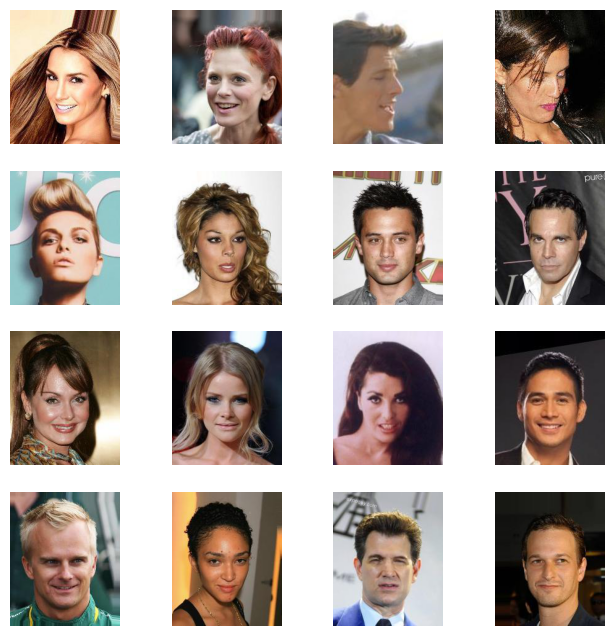

In [7]:
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(dataset["train"][i]["image"])
    plt.axis("off")


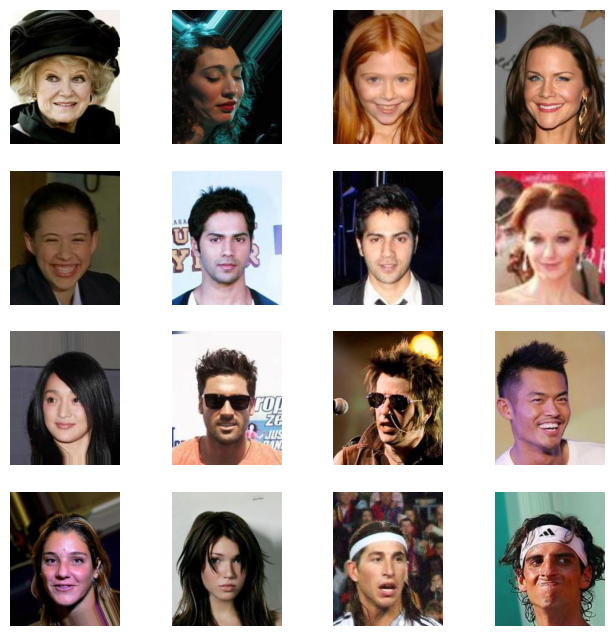

In [8]:
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(dataset["validation"][i]["image"])
    plt.axis("off")

## Model

The model is implemented as discussed in the slides. The output of the *encoder* is not a single point; instead, it is a mean, $\mu$, and a standard deviation, $\sigma$. At this stage, a sample $\varepsilon \sim N(0,1)$ is drawn from a normal distribution, and the latent representation to be decoded is computed as $\mu + \sigma \cdot \varepsilon$. This operation is valid despite the non-differentiable nature of sampling because this part of the process does not involve parameters to optimize. This technique is known as the *reparameterization trick*.  

For the layers in the *encoder* and the *decoder*, I use simple convolutional blocks with batch normalization and Leaky Relu activation. These blocks will be created in a symmetrical fashion for the encoder and decoder.

In [9]:
class VAE(nn.Module):
    def __init__(self, latent_dim=256, activation_cls=nn.LeakyReLU):
        super(VAE, self).__init__()

        # Encoder
        def get_encoder_block(input_channels, output_channels):
            return [
                nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(output_channels),
                activation_cls(),
            ]

        self.encoder = nn.Sequential(
            *get_encoder_block(3, 32),  # 3x64x64 -> 32x32x32
            *get_encoder_block(32, 64),  # 32x32x32 -> 64x16x16
            *get_encoder_block(64, 128),  # 64x16x16 -> 128x8x8
            *get_encoder_block(128, 256),  # 128x8x8 -> 256x4x4
            *get_encoder_block(256, 512),  # 256x4x4 -> 512x2x2
            nn.Flatten(),  # 512x2x2 -> 2048
        )

        # Latent space
        self.fc_mu = nn.Linear(2048, latent_dim)
        self.fc_logvar = nn.Linear(2048, latent_dim)

        # Decoder
        def get_decoder_block(input_channels, output_channels):
            return [
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(output_channels),
                activation_cls(),
            ]

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 2048),
            activation_cls(),
            nn.Unflatten(1, (512, 2, 2)),  # 2048 -> 512x2x2
            *get_decoder_block(512, 256),  # 512x2x2 -> 256x4x4
            *get_decoder_block(256, 128),  # 256x4x4 -> 128x8x8
            *get_decoder_block(128, 64),  # 128x8x8 -> 64x16x16
            *get_decoder_block(64, 32),  # 64x16x16 -> 32x32x32
            *get_decoder_block(32, 16),  # 32x32x32 -> 16x64x64
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),  # 16x64x64 -> 3x64x64
            nn.Sigmoid(),
        )
        

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.__reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar

    def __reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # std = e^(0.5 * log(var)) = (e^log(var))^0.5 = var^0.5 = std
        eps = torch.randn_like(std)
        return mu + eps * std


## Training

Let's define all the training parameters here:

In [10]:
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0.
MAX_EPOCHS = 50
BETA_KL = 1. / 200.  # to weight the KL term in the loss
LATENT_DIM = 256

I define a PyTorch Lightning module, which simplifies the management of various
training variables such as floating-point precision, devices for training,
callbacks, and checkpoints. This framework allows for streamlined and modular
training while abstracting away many implementation details, enabling a focus on
model design and performance tuning.

In [11]:
class VAELightningModule(pl.LightningModule):
    def __init__(
        self,
        latent_dim: int = 256,
        optimizer_params: dict = None,
        beta_kl: float = 1.,
    ):
        super(VAELightningModule, self).__init__()
        self.save_hyperparameters()
        self.model = VAE(latent_dim=latent_dim)
        self.optimizer_params = optimizer_params
        self.beta_kl = beta_kl

    def training_step(self, batch, batch_idx):
        x, _ = batch
        recon_batch, mu, logvar = self.model(x)
        loss, mse, kld = self.__loss_fn(recon_batch, x, mu, logvar)
        self.log_dict(
            {'train_mse_step': mse, 'train_kld_step': kld, 'train_loss_step': loss}, 
            on_step=True, on_epoch=False, prog_bar=True, logger=False
        )
        self.log_dict(
            {'train_mse': mse, 'train_kld': kld, 'train_loss': loss},
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, _ = batch
        recon_batch, mu, logvar = self.model(x)
        loss, _, _ = self.__loss_fn(recon_batch, x, mu, logvar)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def __loss_fn(self, recon_x, x, mu, logvar):
        mse_val = F.mse_loss(recon_x, x, reduction='mean')
        kld_val = 0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return mse_val - kld_val * self.beta_kl, mse_val, kld_val

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters(), **self.optimizer_params)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step',
            }
        }

    def configure_callbacks(self):
        return [
            pl.callbacks.ModelCheckpoint(monitor='val_loss'),
            pl.callbacks.EarlyStopping(monitor='val_loss', patience=6, mode='min'),
        ]

To understand the loss function, it is first necessary to grasp the concept of the Kullback-Leibler divergence.  

KL divergence is a measure of how one probability distribution $P$ differs from another distribution $Q$. In the context of VAEs, it is used to measure how much the distribution learned by the model deviates from a target distribution, typically the normal distribution $\mathcal{N}(0, I)$. It is defined as:  

$$
KL(P \| Q) = \int P(x) \log\frac{P(x)}{Q(x)} dx
,$$  
where $P$ is the true data distribution and $Q$ is the distribution modeled by the VAE.  

The VAE loss function comprises two components:  

1. **Reconstruction**: Measures the quality of the input reconstruction, in our case using the mean squared error.  
2. **KL Regularization**: This term uses the KL divergence to enforce the latent representation's distribution to approximate a standard normal distribution. It is calculated between the normal distribution defined by $\mu$ and $\sigma$ and the standard normal distribution $\mathcal{N}(0, I)$.  

The KL divergence can be efficiently computed for these two normal distributions as follows:  

$$
KL(\mathcal{N}(\mu, \sigma^2) \| \mathcal{N}(0, I)) = \frac{1}{2} \sum_{k} (\sigma_k^2 + \mu_k^2 - \log \sigma_k^2 - 1)
$$  

where $k$ indexes the dimensions of the latent representation.

Finally, let's train the model!

In [12]:
optimizer_params = {
    'lr': LEARNING_RATE,
    'weight_decay': WEIGHT_DECAY,
}
module = VAELightningModule(optimizer_params=optimizer_params, beta_kl=BETA_KL)
data_module = CelebADataModule(TRAIN_BATCH_SIZE, VAL_BATCH_SIZE)
data_module.setup()

In [13]:
trainer = pl.Trainer(
    accelerator='gpu',  # comment this line if you don't have a GPU!
    devices=[0],  # comment this line if you don't have a GPU!
    max_epochs=MAX_EPOCHS,
    precision="32",
    gradient_clip_val=1.0,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/pablo/.micromamba/envs/mdl_gen/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [87]:
trainer.fit(module, data_module)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name  | Type | Params
-------------------------------
0 | model | VAE  | 4.7 M 
-------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.877    Total estimated model params size (MB)


Epoch 36: 100%|██████████| 318/318 [00:49<00:00,  6.47it/s, v_num=8, train_mse_step=0.00659, train_kld_step=-0.553, train_loss_step=0.00935, val_loss=0.0091, train_mse=0.00607, train_kld=-0.548, train_loss=0.00881] 


## Usage examples

In this section, we see a series of examples of how to use this type of model.
The first thing we will do is load a checkpoint, in case there isn't already a
model in memory because the *notebook* hasn't been fully executed. The one I
load here can be downloaded from [this
link](https://upm365-my.sharepoint.com/:u:/g/personal/pablo_miralles_upm_es/EauLsx3Wx89OsT5gxOWUPLcBf0RK6wDZqcp6p2Z7pSZvNg?e=mTXrzT).

In [18]:
module = VAELightningModule.load_from_checkpoint(
    "logs/lightning_logs/version_8/checkpoints/epoch=30-step=9858.ckpt",
)

### Image reconstruction

Let's begin by reconstructing faces from the validation set:

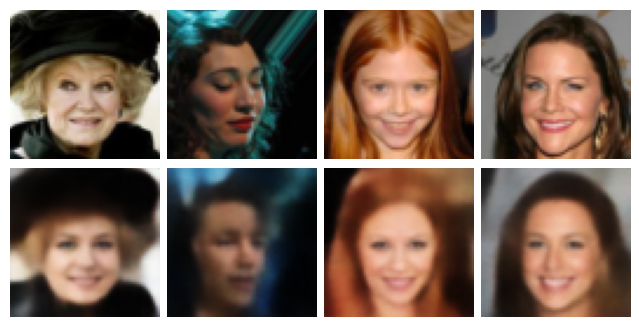

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = module.model.to(device)

fig, axes = plt.subplots(2, 4, figsize=(8, 4))
model.eval()
with torch.no_grad():
    x, _ = next(iter(data_module.val_dataloader()))
    x = x[:4]
    recon_x, _, _ = model(x.to(device))
    for i in range(4):
        axes[0, i].imshow(np.transpose(x[i].cpu(), (1, 2, 0)))
        axes[1, i].imshow(np.transpose(recon_x[i].squeeze(0).cpu().float(), (1, 2, 0)))
        axes[0, i].set_axis_off()
        axes[1, i].set_axis_off()

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

Not bad, but definitely not good.

### Generating new images

We should be able to obtain new images by sampling from a normal distribution and decoding!

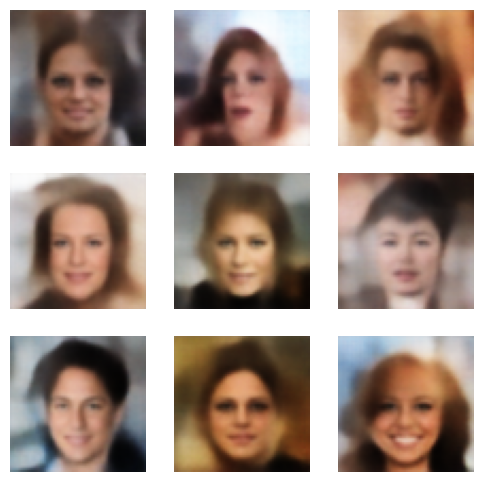

In [91]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = module.model.to(device)

def generate_random_images(model, num_images):
    model.eval()
    with torch.no_grad():
        # Sample random latent vectors
        z = torch.randn(num_images, LATENT_DIM).to(device)
        # Generate images
        generated_images = model.decoder(z)
    return generated_images

# Generate and visualize images
generated_images = generate_random_images(model, 9)
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(generated_images[i*3+j].float().cpu().permute(1, 2, 0))
        ax[i, j].axis('off')

Welp, not too great unfortunately.

### Conditioning the generation based on an attribute

The faces in our *dataset* come with a series of attributes. We can select a
specific attribute, such as gender, and compute the mean vector and standard
deviations for its two possible values. We can then sample from these
distributions conditioned on that attribute.

In [26]:
@torch.no_grad()
def generate_class_distributions(model, attr_key, data_loader):
    model.eval()

    positive_mus = []
    positive_stds = []

    negative_mus = []
    negative_stds = []

    for (x, attr) in data_loader:
        _, mu, logvar = model(x.to(device))
        positive_inds = torch.tensor([i for i, a in enumerate(attr) if a[attr_key] == 1])
        negative_inds = torch.tensor([i for i, a in enumerate(attr) if a[attr_key] != 0])

        positive_mus.append(mu[positive_inds])
        positive_stds.append(torch.exp(0.5 * logvar[positive_inds]))
        negative_mus.append(mu[negative_inds])
        negative_stds.append(torch.exp(0.5 * logvar[negative_inds]))
    
    positive_mu = torch.mean(torch.cat(positive_mus, dim=0), dim=0)
    positive_std = torch.mean(torch.cat(positive_stds, dim=0), dim=0)
    negative_mu = torch.mean(torch.cat(negative_mus, dim=0), dim=0)
    negative_std = torch.mean(torch.cat(negative_stds, dim=0), dim=0)

    return positive_mu, positive_std, negative_mu, negative_std

In [29]:
positive_mu, positive_std, negative_mu, negative_std = generate_class_distributions(model, "Male", data_module.val_dataloader())

(-0.5, 63.5, 63.5, -0.5)

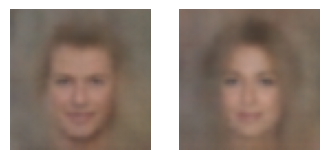

In [37]:
z1 = torch.randn(1, LATENT_DIM).to(device)
z1 = positive_mu + positive_std * z1

z2 = torch.randn(1, LATENT_DIM).to(device)
z2 = negative_mu + negative_std * z2

model.eval()
with torch.no_grad():
    img_1 = model.decoder(z1)
    img_2 = model.decoder(z2)

fig, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].imshow(img_1.squeeze(0).cpu().permute(1, 2, 0))
axes[1].imshow(img_2.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[1].axis('off')

As we can see, the face on the left is more masculine and the one on the right
more feminine, although if we retry there is a lot of variance from the sampling
operation. Again, the quality of the images is not particularly great.

We will now try to take a male face and turn it female. To do this, we need a
vector in the latent space that represents this change. But this is precisely
the difference of the vectors $\mu_-$ and $\mu_+$ we calculated in the previous
example! We take this difference vector and add it with different strengths to
the latent representation of a male face.

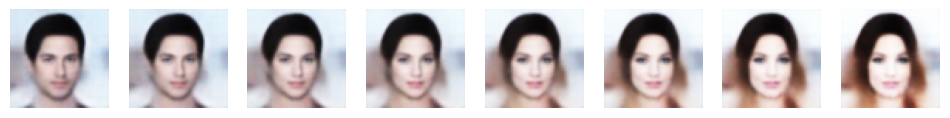

In [58]:
NUM_STEPS = 8

make_female = negative_mu - positive_mu
img = next(iter(data_module.val_dataloader()))[0][5]

model.eval()
with torch.no_grad():
    # Encode image
    _, mu, logvar = model(img.unsqueeze(0).to(device))
    # Modify latent vector
    img_dec = []
    for idx in range(NUM_STEPS):
        z = mu + idx * make_female
        img_dec.append(model.decoder(z))

fig, axes = plt.subplots(1, NUM_STEPS, figsize=(12, 2))
for i in range(NUM_STEPS):
    axes[i].imshow(img_dec[i].squeeze(0).cpu().permute(1, 2, 0))
    axes[i].axis('off')

It works!

### Image interpolation

As a final use case, we attempt to take two images from the validation dataset
and interpolate them in the latent space to generate intermediate faces.

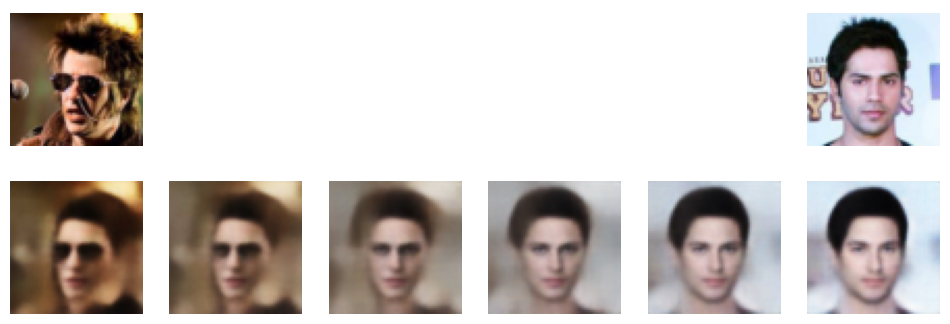

In [59]:
NUM_STEPS = 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = module.model.to(device)

img_1 = next(iter(data_module.val_dataloader()))[0][5]
img_2 = next(iter(data_module.val_dataloader()))[0][10]

model.eval()
with torch.no_grad():
    z_1 = model.fc_mu(model.encoder(img_1.unsqueeze(0).to(device))[0])
    z_2 = model.fc_mu(model.encoder(img_2.unsqueeze(0).to(device))[0])

    z_interp = torch.zeros(NUM_STEPS, LATENT_DIM).to(device)
    for i, alpha in enumerate(np.linspace(0, 1, NUM_STEPS)):
        z_interp[i] = alpha * z_1 + (1 - alpha) * z_2

    generated_images = model.decoder(z_interp)
    fig, ax = plt.subplots(2, NUM_STEPS, figsize=(NUM_STEPS * 2, 4))
    for i in range(NUM_STEPS):
        ax[1, i].imshow(generated_images[i].float().cpu().permute(1, 2, 0))
        ax[0, i].axis('off')
        ax[1, i].axis('off')

    ax[0, -1].imshow(np.transpose(img_1, (1, 2, 0)))
    ax[0, 0].imshow(np.transpose(img_2, (1, 2, 0)))